In [1]:
import datetime
import math
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as image
from matplotlib.offsetbox import  OffsetImage

#matplotlib inline
import pyproj
import pymap3d as pm

from astropy.time import Time



In [2]:
## input data
data = pd.read_csv("data/turkeq/rodo_kin03700_23.cts", sep=" ")

#data["dates"]
data['Lat'], data['Lon'], data['Alt'] = pm.ecef2geodetic(data['X'], data['Y'], data['Z'], ell=None, deg=True)
#data['ddate'] = pd.to_datetime(data['dates'], format='%d/%m/%Y')
#data['date'] = pd.to_datetime(data.date + data.h.astype(str),format='%d/%m/%Y %H').dt.time
#data['date']
#data['time'] =data['h'].astype(str) +':'+ data['min'].astype(str)+':'+data['sec'].astype(str)
#data['date'] = pd.to_datetime(data['ddate'].astype(str) +' '+ data['time'].astype(str))
#data['jd'] = data['mjd'] + 2400000.5

data['mjdTim'] = data['mjd']+data['sod']/(3600*24)

data['Date'] = Time(data['mjdTim'], format='mjd').datetime

#P = pyproj.Proj(proj='utm', zone=34, ellps='WGS84', preserve_units=False)
#data['utmE'], data['utmN'] = P(data['Lon'], data['Lat'])

## set index
data = data.set_index(['Date'])
data
## convert and make index to dataframwe
#time_data = "3/4/2022 12:16:25.123"
#format_data = "%d/%m/%Y"
#date = datetime.strptime(data['dates'], format_data)
#data
header= ['X','Y','Z',]
data.to_csv('data/test_p2.txt', columns=header)
#utmout = data[['utmE', 'utmN', 'Alt']].copy()
#
#utmout
#utmout.to_csv('Outputs/utm_ts.txt')
data

,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim
Date,,,,,,,,,
2023-02-06 00:00:00,59981,0.0,4537597.436,2429130.561,3754440.070,36.292603,28.161661,51.142487,59981.000000
2023-02-06 00:00:01,59981,1.0,4537597.438,2429130.564,3754440.069,36.292603,28.161661,51.144458,59981.000012
2023-02-06 00:00:02,59981,2.0,4537597.439,2429130.566,3754440.072,36.292603,28.161661,51.147705,59981.000023
2023-02-06 00:00:03,59981,3.0,4537597.441,2429130.565,3754440.072,36.292603,28.161661,51.148746,59981.000035
2023-02-06 00:00:04,59981,4.0,4537597.436,2429130.562,3754440.070,36.292603,28.161661,51.142868,59981.000046
...,...,...,...,...,...,...,...,...,...
2023-02-06 21:59:55,59981,79195.0,4537597.480,2429130.568,3754440.094,36.292603,28.161661,51.190622,59981.916609
2023-02-06 21:59:56,59981,79196.0,4537597.477,2429130.569,3754440.093,36.292603,28.161661,51.188279,59981.916620
2023-02-06 21:59:57,59981,79197.0,4537597.482,2429130.572,3754440.094,36.292603,28.161661,51.193565,59981.916632


In [3]:
## convert to E N UP
meanX=data['X'].mean()
meanY=data['Y'].mean()
meanZ=data['Z'].mean()

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#mLon, mLat, mAlt = pyproj.transform(ecef, lla, meanX, meanY, meanZ, radians=False)
mLat, mLon, mAlt = pm.ecef2geodetic(meanX, meanY, meanZ,  ell=None, deg=True)


print(mLon, mLat, mAlt)

# mLon_r=math.radians(mLon)
# mLat_r=math.radians(mLat)
# print(meanLon, meanLat, meanAlt)

data['dX'] = data['X'] - meanX
data['dY'] = data['Y'] - meanY
data['dZ'] = data['Z'] - meanZ

## make rotational matrix
#R = [ 
#    [-math.sin(mLat_r)*math.cos(mLon_r), -math.sin(mLat_r)*math.sin(mLon_r), math.cos(mLat_r)],
#    [-math.sin(mLon_r), math.cos(mLon_r), 0],
#    [math.cos(mLat_r)*math.cos(mLon_r), math.cos(mLat_r)*math.sin(mLon_r), math.sin(mLat_r)]
#]


data['dE'], data['dN'], data['dU'] = pm.ecef2enu(data['X'], data['Y'], data['Z'], mLat, mLon, mAlt, ell=None, deg=True)
data['dN'] = data['dN']*1000.
data['dE'] = data['dE']*1000.
data['dU'] = data['dU']*1000.

#indexdN = data[ (data['dN'] >= 40) | (data['dN'] <=-40) ].index
#data.drop(indexdN , inplace=True)
header= ['X','Y','Z','dN', 'dE', 'dU']
data.to_csv('test_p.csv', columns=header)
data

28.161661078139396 36.29260315191568 51.18210086956137


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU
Date,,,,,,,,,,,,,,,
2023-02-06 00:00:00,59981,0.0,4537597.436,2429130.561,3754440.070,36.292603,28.161661,51.142487,59981.000000,-0.033361,-0.016683,-0.016153,1.037436,9.049748,-39.613555
2023-02-06 00:00:01,59981,1.0,4537597.438,2429130.564,3754440.069,36.292603,28.161661,51.144458,59981.000012,-0.031361,-0.013683,-0.017153,2.738372,6.361992,-37.643077
2023-02-06 00:00:02,59981,2.0,4537597.439,2429130.566,3754440.072,36.292603,28.161661,51.147705,59981.000023,-0.030361,-0.011683,-0.014153,4.029650,7.699452,-34.395955
2023-02-06 00:00:03,59981,3.0,4537597.441,2429130.565,3754440.072,36.292603,28.161661,51.148746,59981.000035,-0.028361,-0.012683,-0.014153,2.204109,6.935133,-33.355179
2023-02-06 00:00:04,59981,4.0,4537597.436,2429130.562,3754440.070,36.292603,28.161661,51.142868,59981.000046,-0.033361,-0.015683,-0.016153,1.919055,8.770390,-39.233153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 21:59:55,59981,79195.0,4537597.480,2429130.568,3754440.094,36.292603,28.161661,51.190622,59981.916609,0.010639,-0.009683,0.007847,-13.557510,3.477456,8.521018
2023-02-06 21:59:56,59981,79196.0,4537597.477,2429130.569,3754440.093,36.292603,28.161661,51.188279,59981.916620,0.007639,-0.008683,0.006847,-11.260007,3.957609,6.177743
2023-02-06 21:59:57,59981,79197.0,4537597.482,2429130.572,3754440.094,36.292603,28.161661,51.193565,59981.916632,0.012639,-0.005683,0.007847,-10.974953,1.316347,11.463808


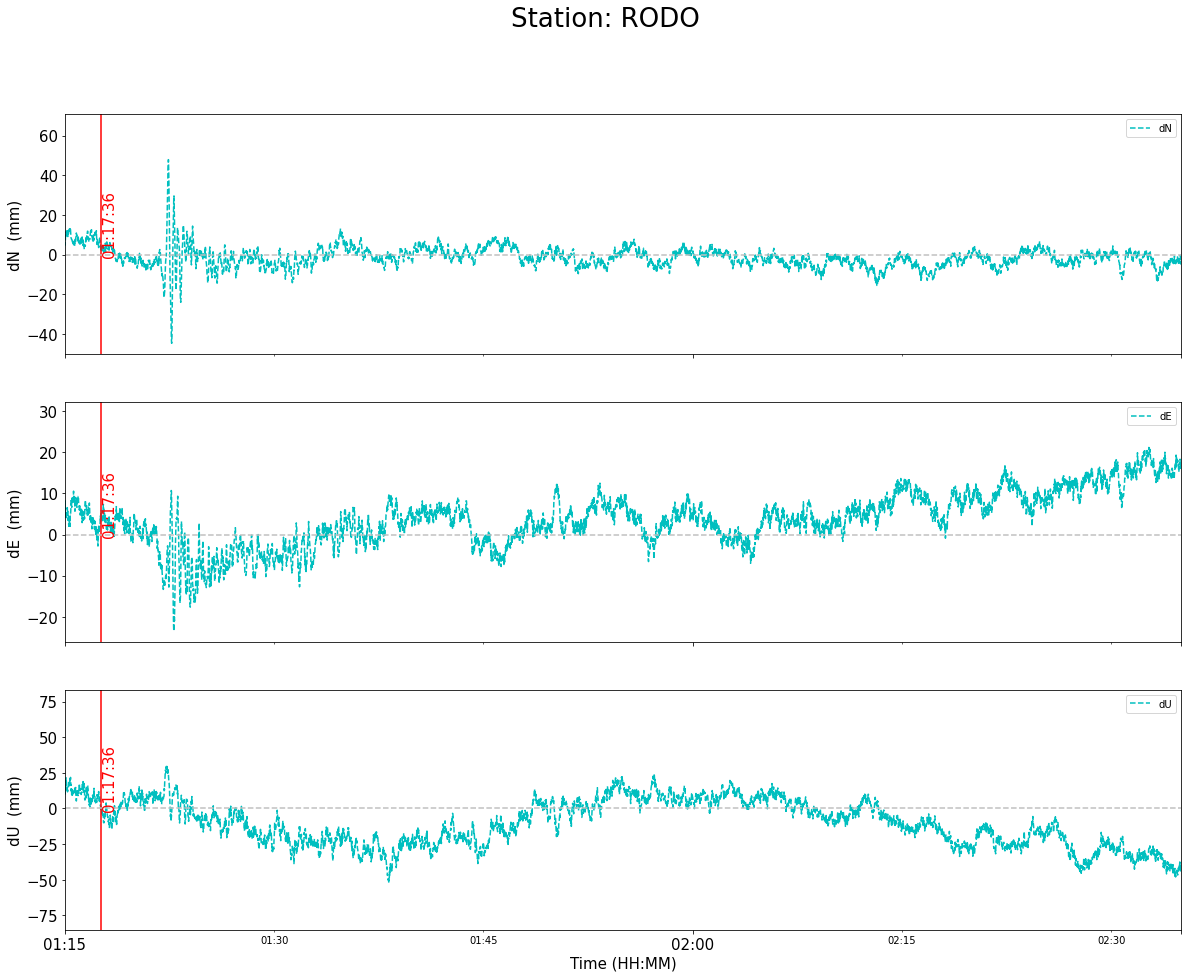

In [4]:
## make time series for the three axes
fig, axes = plt.subplots(3, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: RODO', fontsize=26)


plot_cols = ['dN', 'dE', 'dU' ]
#plot_cols = ['dX', 'dY', 'dZ' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
    ax.set_xlim([pd.Timestamp('2023-02-06 01:15:00'), pd.Timestamp('2023-02-06 02:35:00')])
#    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
#    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
#    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)
    ax.axhline(y=0, linestyle='--', color='silver')
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')
##########0117
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 01:19:50'), pd.Timestamp('2023-02-06 01:25:20'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 01:23:30'), pd.Timestamp('2023-02-06 01:25:40'), alpha=0.1, color='r') #DYNG
##########1024
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:50'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:30'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 10:29:37'), pd.Timestamp('2023-02-06 10:31:00'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 10:26:10'), pd.Timestamp('2023-02-06 10:32:40'), alpha=0.1, color='r') #DYNG


In [5]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur/RODO_20230371024.jpg")
## =================================================================================

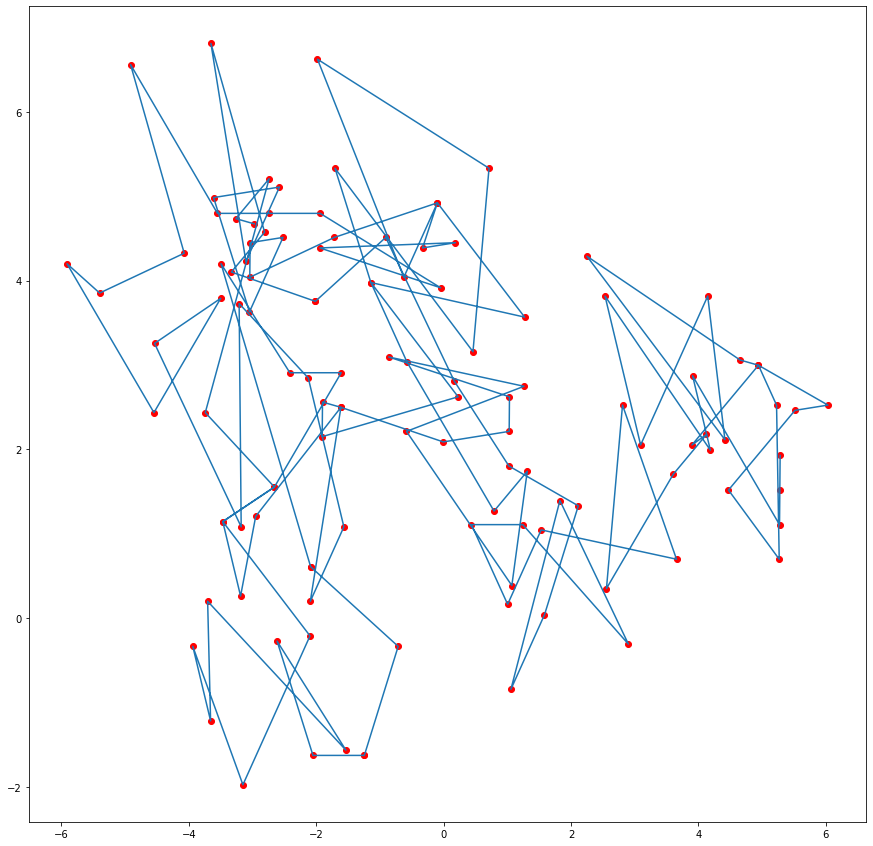

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
DN=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dN']
DE=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dE']
ax.scatter(DN, DE, marker='o',linestyle='-', color='r') 
ax.plot(DN, DE, marker='',linestyle='-') 

In [7]:
#from hhpy.plotting import animplot

#animplot(data=data, x='dE', y='dN', t='sod', t_format='%S')

In [8]:
#anim.save('Outputs/230206_tur/animation.gif', writer='imagemagick', fps=60)

#data.index